Is there a general algorithm for solving resistive circuits?

The difficult part is that order matters, and some operations aren't reversible. Once you contract a node you break symmetry. You have to be smart about which ones to contract, replace, etc. so it's the right shape

general operations:
- series/parallel
- connect equipotential nodes
- wye delta

for a nxn lattice:
1. fold along line of symmetry (join two equipotential nodes)
2. collapse along line of equipotential
3. get rid of leaf nodes
4. apply series and parallel circuits

solving 4x4 resistive lattice with battery connected along the diagonal of center square

In [1]:
import networkx as nx

In [2]:
def create_lattice(N):
  G = nx.grid_2d_graph(2*N, 2*N)
  for (u, v) in G.edges():
    G[u][v]['weight'] = 1
  G.add_edge((N-1,N-1),(N,N)) # battery
  return G

In [3]:
def simplify_weights(G):
  '''replace parallel weights after contraction'''
  for u, v, data in G.edges(data=True):
    if 'contraction' in data:
      total_weight = 1/data['weight']
      for contracted_edge in data['contraction'].values():
        total_weight += 1/contracted_edge.get('weight', 0)
      G[u][v]['weight'] = 1/total_weight # parallel resistors
      del G[u][v]['contraction']
  return G

In [4]:
def fold(G,N):
  '''fold along diagonal (line of symmetry)'''
  pairs = [((x,y), (y,x)) for x in range(2*N) for y in range(2*N)]

  for (n1,n2) in pairs:
    if n1 in G and n2 in G:
      G = nx.contracted_nodes(G, n1, n2)
  return simplify_weights(G)

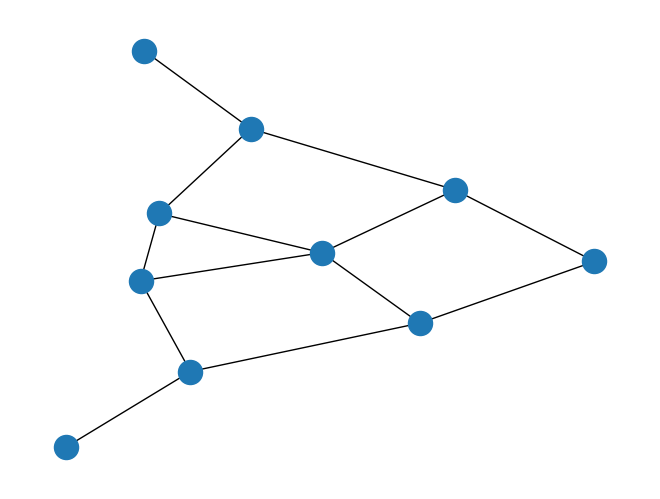

In [5]:
N=2
G = create_lattice(N)
folded_G = fold(G,N)
nx.draw(folded_G)

In [6]:
len(list(G.edges(data=True)))

25

In [7]:
print(list(folded_G.edges(data=True))[:10])
len(list(folded_G.edges(data=True))) # half as many edges after

[((0, 1), (0, 2), {'weight': 0.5}), ((0, 1), (0, 0), {'weight': 0.5}), ((0, 1), (1, 1), {'weight': 0.5}), ((0, 2), (1, 2), {'weight': 0.5}), ((0, 2), (0, 3), {'weight': 0.5}), ((0, 3), (1, 3), {'weight': 0.5}), ((1, 2), (1, 3), {'weight': 0.5}), ((1, 2), (1, 1), {'weight': 0.5}), ((1, 2), (2, 2), {'weight': 0.5}), ((1, 3), (2, 3), {'weight': 0.5})]


13

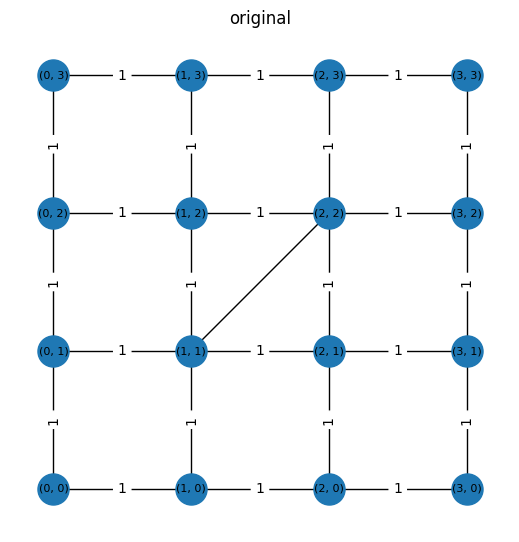

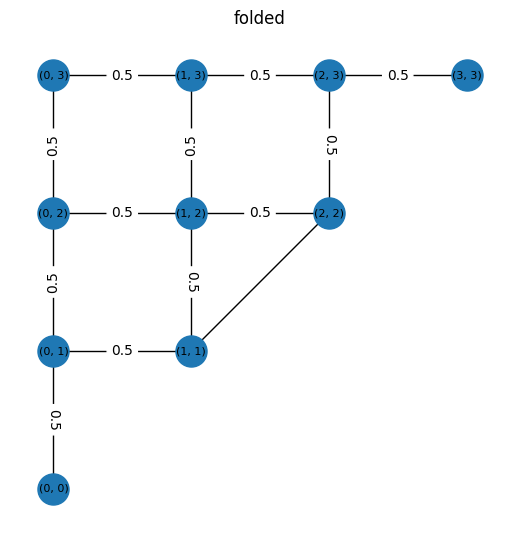

In [8]:
import matplotlib.pyplot as plt
def display_graph(G, title):
  pos = {node: node for node in G.nodes()}
  plt.figure(figsize=(5, 5))
  nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
  plt.title(title)
  plt.axis('off')
  plt.show()

display_graph(G, "original")
display_graph(folded_G, "folded")

In [9]:
def fold2(G,N):
  '''contract along other diagonal, only diag elements'''
  pairs = [((x,2*N-x-1), (x+1,2*N-x-2)) for x in range(2*N-1)] # starts on bottom left
  print(pairs)

  for (n1,n2) in pairs:
    if n1 in G and n2 in G:
      G = nx.contracted_nodes(G, n1, n2)
  return simplify_weights(G)

[((0, 3), (1, 2)), ((1, 2), (2, 1)), ((2, 1), (3, 0))]


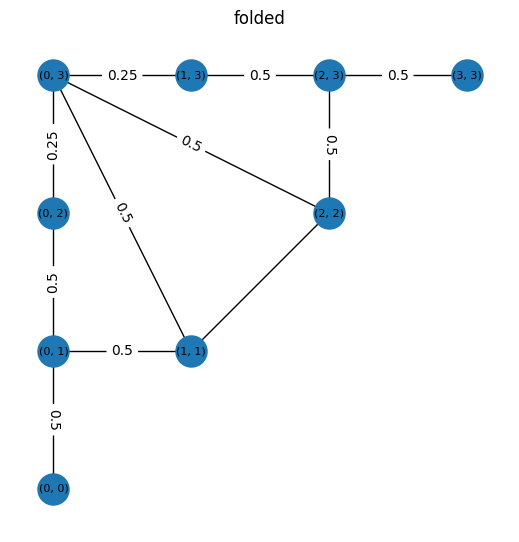

In [10]:
folded_G2 = fold2(folded_G,N)
display_graph(folded_G2, "folded")

In [ ]:
# get rid of leaf nodes, simplify series and parallel resistors
def remove_leaf(G):
  G = G.copy()
  leaf_nodes = [node for node, degree in dict(G.degree()).items() if degree == 1]
  G.remove_nodes_from(leaf_nodes)
  return G

def simplify_series(G):
  '''find all nodes with 2 neighbors (series = share exclusive node)'''
  for node in list(G.nodes()):
    neighbors = list(G.neighbors(node))
    if len(neighbors) == 2:
      n1, n2 = neighbors
      if 'weight' in G[node][n1] and 'weight' in G[node][n2]:
        w1 = G[node][n1]['weight']
        w2 = G[node][n2]['weight']
        new_weight = w1 + w2
        G.remove_node(node)
        if G.has_edge(n1,n2):
          if 'weight' in G[n1][n2]:
            w_old = G[n1][n2]['weight']
            new_weight = (new_weight * w_old) / (new_weight + w_old) # parallel
        G.add_edge(n1, n2, weight=new_weight)
        print(f"Removed node {node} and connected {n1} and {n2} with weight {new_weight}")
  return G


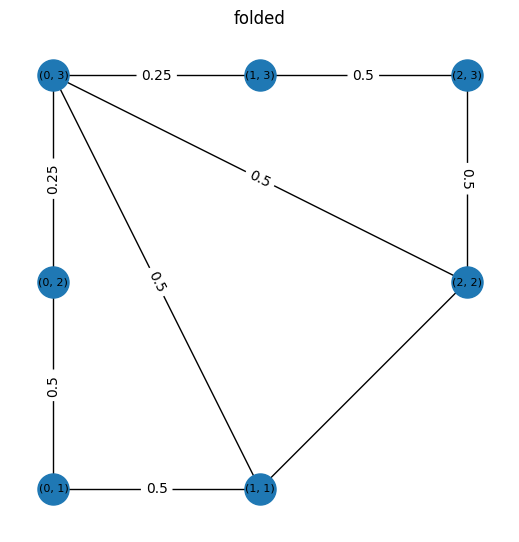

In [35]:

def simplify_series(G):
    '''find all nodes with 2 neighbors (series = share exclusive node)'''
    for node in list(G.nodes()):
        neighbors = list(G.neighbors(node))
        if len(neighbors) == 2:
            n1, n2 = neighbors
            if 'weight' in G[node][n1] and 'weight' in G[node][n2]:
                w1 = G[node][n1]['weight']
                w2 = G[node][n2]['weight']
                new_weight = w1 + w2
                G.remove_node(node)
                if G.has_edge(n1,n2):
                    if 'weight' in G[n1][n2]:
                        w_old = G[n1][n2]['weight']
                        new_weight = (new_weight * w_old) / (new_weight + w_old) # parallel
                G.add_edge(n1, n2, weight=new_weight)
                print(f"Removed node {node} and connected {n1} and {n2} with weight {new_weight}")
    return G

folded_G3 = remove_leaf(folded_G2)
display_graph(folded_G3, "folded")

Removed node (0, 1) and connected (0, 2) and (1, 1) with weight 1.0
Removed node (0, 2) and connected (0, 3) and (1, 1) with weight 0.35714285714285715
Removed node (1, 3) and connected (0, 3) and (2, 3) with weight 0.75
Removed node (2, 3) and connected (2, 2) and (0, 3) with weight 0.35714285714285715


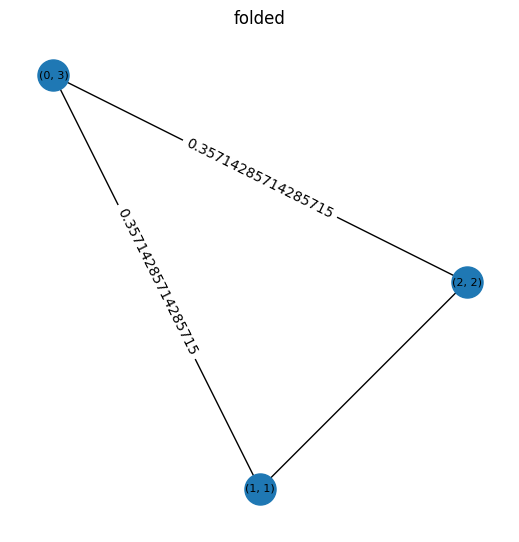

In [36]:
folded_G4 = simplify_series(folded_G3)
display_graph(folded_G4, "folded")

In [37]:
print(list(folded_G4.edges(data=True))[:10])
len(list(folded_G4.edges(data=True))) # half as many edges after

[((0, 3), (1, 1), {'weight': 0.35714285714285715}), ((0, 3), (2, 2), {'weight': 0.35714285714285715}), ((1, 1), (2, 2), {})]


3

Removed node (0, 3) and connected (1, 1) and (2, 2) with weight 0.7142857142857143


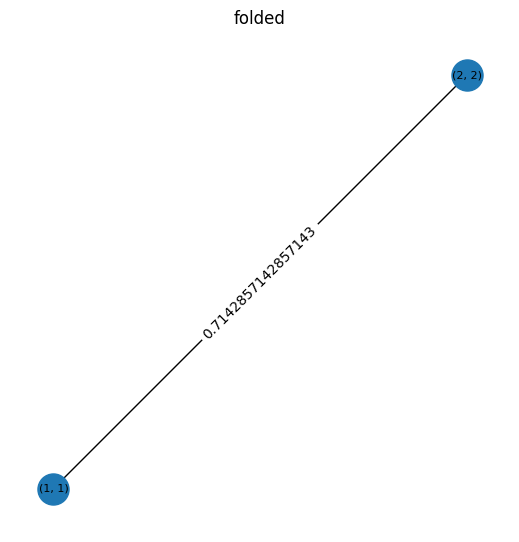

In [38]:
folded_G5 = simplify_series(folded_G4)
display_graph(folded_G5, "folded")
# overall R_eq: 5/7

In [41]:
for u, v in folded_G5.edges:
  print(folded_G5[u][v]['weight'])

0.7142857142857143
